In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.metrics import confusion_matrix
import seaborn as sns
from PIL import Image

In [3]:
# Ustawienie ziarna dla powtarzalności
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Urządzenie
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [4]:
# Transformacje danych
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Dane
full_trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_indices = list(range(0, int(len(full_trainset) * 0.85)))
validation_indices = list(range(int(len(full_trainset) * 0.85), len(full_trainset)))
trainset = Subset(full_trainset, train_indices)
validation_set = Subset(full_trainset, validation_indices)

trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
validation_loader = DataLoader(validation_set, batch_size=64, shuffle=False)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

Epoch 1/3, Train Loss: 0.1221, Train Accuracy: 96.26%, Validation Loss: 0.0516, Validation Accuracy: 98.43%
Epoch 2/3, Train Loss: 0.0467, Train Accuracy: 98.54%, Validation Loss: 0.0636, Validation Accuracy: 98.30%
Epoch 3/3, Train Loss: 0.0336, Train Accuracy: 98.96%, Validation Loss: 0.0516, Validation Accuracy: 98.62%

Test Loss: 0.0580, Test Accuracy: 98.46%


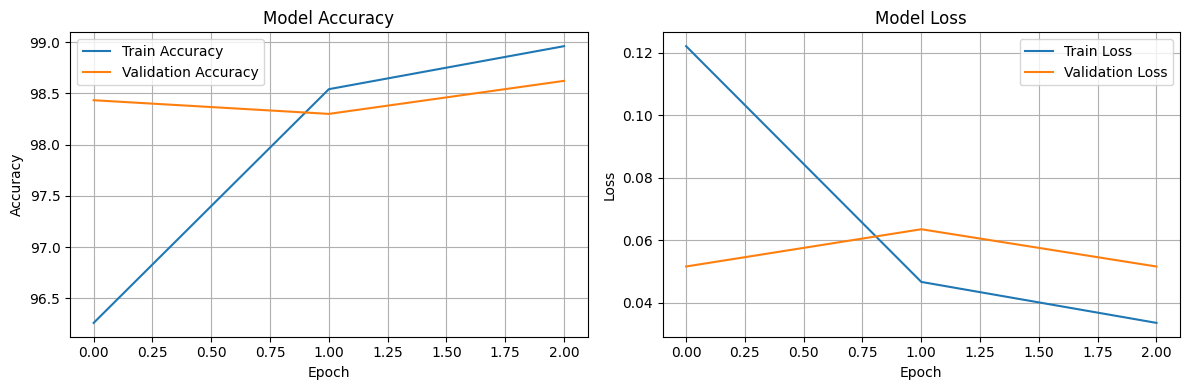

Model zapisany jako 'mnist_model.pth'
Zapisano X_test i y_test


In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * 14 * 14, 128)
        self.fc2 = nn.Linear(128, 10)
        self.act = nn.GELU()

    def forward(self, x):
        x = self.conv1(x)
        x = self.act(x)
        x = self.conv2(x)
        x = self.act(x)
        x = self.pool(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.act(x)
        x = self.fc2(x)
        return x

# Inicjalizacja modelu, straty i optymalizatora
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0015)

# Funkcja treningu
def train_model(model, trainloader, validloader, epochs=10):
    train_losses, valid_losses = [], []
    train_accuracies, valid_accuracies = [], []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(trainloader)
        train_acc = 100 * correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        # Walidacja
        model.eval()
        valid_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in validloader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                valid_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        valid_loss = valid_loss / len(validation_loader)
        valid_acc = 100 * correct / total
        valid_losses.append(valid_loss)
        valid_accuracies.append(valid_acc)

        print(f"Epoch {epoch+1}/{epochs}, "
              f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%, "
              f"Validation Loss: {valid_loss:.4f}, Validation Accuracy: {valid_acc:.2f}%")

    return train_losses, valid_losses, train_accuracies, valid_accuracies

# Trening
train_losses, valid_losses, train_accuracies, valid_accuracies = train_model(model, trainloader, validation_loader, epochs=3)

# Testowanie
model.eval()
test_loss, correct, total = 0.0, 0, 0
with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_loss = test_loss / len(testloader)
test_acc = 100 * correct / total
print(f"\nTest Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")

# Wizualizacja
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(valid_accuracies, label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Zapis modelu i danych
torch.save(model.state_dict(), "mnist_model.pth")
print("Model zapisany jako 'mnist_model.pth'")
np.save("X_test.npy", testset.data.numpy())
np.save("y_test.npy", testset.targets.numpy())
print("Zapisano X_test i y_test")

Model załadowany z 'mnist_model.pth'
Załadowano X_test i y_test


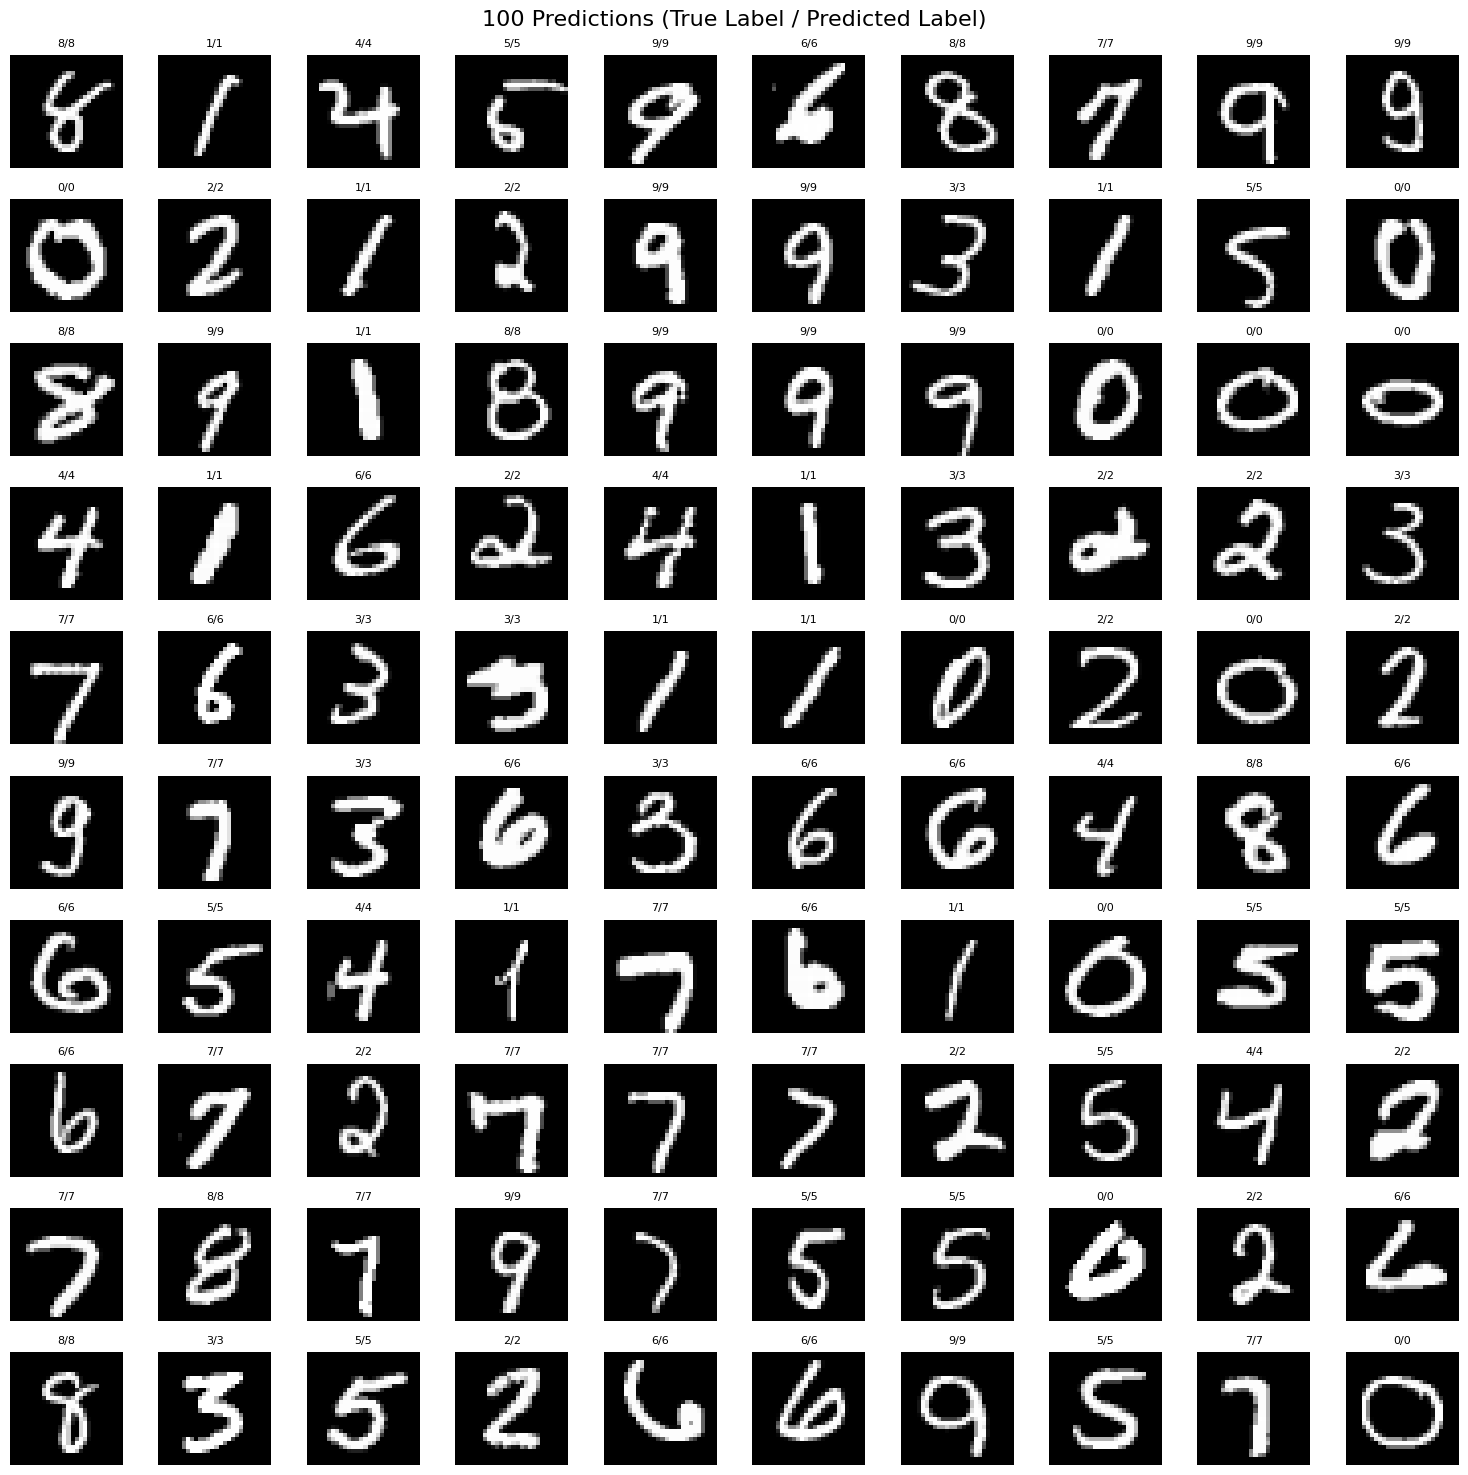

Zapisano siatkę predykcji jako '100_predictions_grid.png'


<Figure size 640x480 with 0 Axes>

In [6]:
model = CNN().to(device)
model.load_state_dict(torch.load("mnist_model.pth"))
model.eval()
print("Model załadowany z 'mnist_model.pth'")

X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
print("Załadowano X_test i y_test")

np.random.seed(None) #42
indices = np.random.choice(len(X_test), 100, replace=False)

images = torch.tensor(X_test[indices], dtype=torch.float32).unsqueeze(1) / 255.0
images = (images - 0.5) / 0.5
images = images.to(device)
true_labels = y_test[indices]

with torch.no_grad():
    outputs = model(images)
    predicted_labels = torch.argmax(outputs, dim=1).cpu().numpy()

fig, axes = plt.subplots(10, 10, figsize=(15, 15))
fig.suptitle("100 Predictions (True Label / Predicted Label)", fontsize=16)

for i, ax in enumerate(axes.flat):
    ax.imshow(X_test[indices[i]], cmap='gray')
    ax.axis('off')
    ax.set_title(f"{true_labels[i]}/{predicted_labels[i]}", fontsize=8)

plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()

plt.savefig("100_predictions_grid.png")
print("Zapisano siatkę predykcji jako '100_predictions_grid.png'")

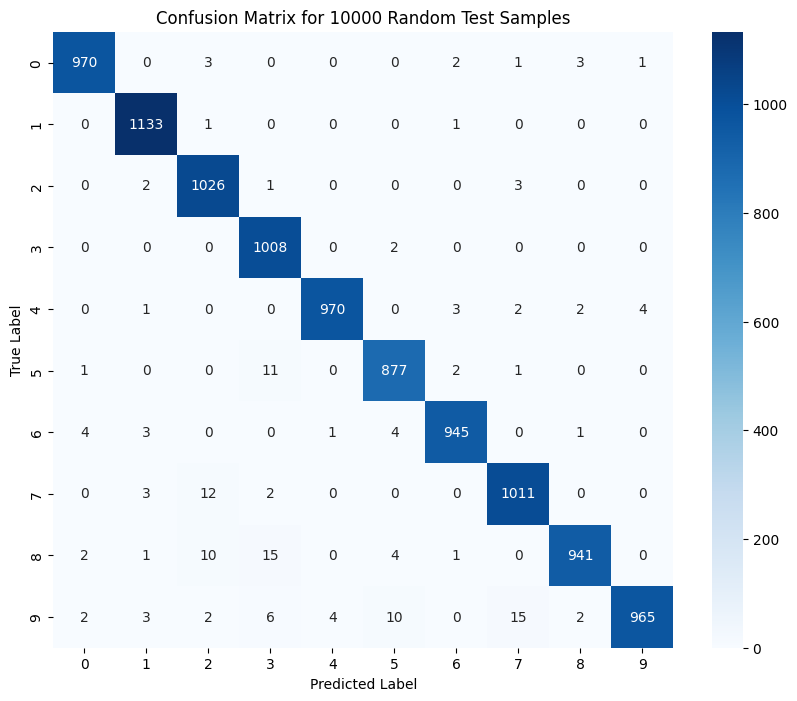

Zapisano macierz pomyłek jako 'confusion_matrix.png'


<Figure size 640x480 with 0 Axes>

In [7]:


indices = np.random.choice(len(X_test), 10000, replace=False)

images = torch.tensor(X_test[indices], dtype=torch.float32).unsqueeze(1) / 255.0
images = (images - 0.5) / 0.5
images = images.to(device)
true_labels = y_test[indices]

with torch.no_grad():
    outputs = model(images)
    predicted_labels = torch.argmax(outputs, dim=1).cpu().numpy()

cm = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.title("Confusion Matrix for 10000 Random Test Samples")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

plt.savefig("confusion_matrix.png")
print("Zapisano macierz pomyłek jako 'confusion_matrix.png'")

In [8]:


def load_and_preprocess_image(image_path):
    img = Image.open(image_path).convert('L')
    transform = transforms.Compose([
        transforms.Resize((28, 28)),
        transforms.ToTensor(),
    ])
    img_tensor = transform(img).unsqueeze(0)
    img_tensor = (img_tensor - 0.5) / 0.5
    return img_tensor.to(device), transform(img)

def predict_image(model, image_tensor):
    with torch.no_grad():
        output = model(image_tensor)
        predicted_label = torch.argmax(output, dim=1).cpu().numpy()[0]
    return predicted_label

def test_custom_image():
    image_path = "cyfra.png"
    try:
        image_tensor, resized_img = load_and_preprocess_image(image_path)
        predicted_label = predict_image(model, image_tensor)
        print(f"Przewidziana cyfra: {predicted_label}")
        
        resized_img_np = resized_img.squeeze().numpy()
        
        plt.figure(figsize=(4, 4))
        plt.imshow(resized_img_np, cmap='gray')
        plt.title(f"Przewidziana cyfra: {predicted_label}")
        plt.axis('off')
        plt.show()
        
    except Exception as e:
        print(f"Błąd: {e}")

test_custom_image()

Błąd: [Errno 2] No such file or directory: 'cyfra.png'
